In [27]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
df=pd.read_csv('flight_delays_train.csv')



print(df.head)
# print(df.loc[(df['dep_delayed_15min'] == 'Y') & (df['UniqueCarrier']=='WN')])

# print(df.UniqueCarrier.unique().size)
print(df.isnull().sum())
data=df.to_numpy()
# num_samples = data.shape[0]
# train_indices = np.random.choice(num_samples, size=int(0.8 * num_samples), replace=False)
# test_indices = np.array(list(set(range(num_samples)) - set(train_indices)))

# train = data[train_indices]
# test = data[test_indices]
# n=train.shape[0]
# print(train[:,-1])


<bound method NDFrame.head of       Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0       c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1       c-4       c-20       c-3     1548            US    PIT  MCO       834   
2       c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3      c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4      c-10        c-7       c-6     1828            WN    MDW  OMA       423   
...     ...        ...       ...      ...           ...    ...  ...       ...   
99995   c-5        c-4       c-3     1618            OO    SFO  RDD       199   
99996   c-1       c-18       c-3      804            CO    EWR  DAB       884   
99997   c-1       c-24       c-2     1901            NW    DTW  IAH      1076   
99998   c-4       c-27       c-4     1515            MQ    DFW  GGG       140   
99999  c-11       c-17       c-4     1800            WN    SEA  SMF       605  

In [28]:
df['Month'] = df['Month'].str.replace('c-', '').astype(int)
df['DayofMonth'] = df['DayofMonth'].str.replace('c-', '').astype(int)
df['DayOfWeek'] = df['DayOfWeek'].str.replace('c-', '').astype(int)
mapping = {'N': 0, 'Y': 1}
df['dep_delayed_15min'] = df['dep_delayed_15min'].map(mapping)
print(df.head)
cate = df.select_dtypes(include=['object']).columns
print(cate)

<bound method NDFrame.head of        Month  DayofMonth  DayOfWeek  DepTime UniqueCarrier Origin Dest  \
0          8          21          7     1934            AA    ATL  DFW   
1          4          20          3     1548            US    PIT  MCO   
2          9           2          5     1422            XE    RDU  CLE   
3         11          25          6     1015            OO    DEN  MEM   
4         10           7          6     1828            WN    MDW  OMA   
...      ...         ...        ...      ...           ...    ...  ...   
99995      5           4          3     1618            OO    SFO  RDD   
99996      1          18          3      804            CO    EWR  DAB   
99997      1          24          2     1901            NW    DTW  IAH   
99998      4          27          4     1515            MQ    DFW  GGG   
99999     11          17          4     1800            WN    SEA  SMF   

       Distance  dep_delayed_15min  
0           732                  0  
1      

In [29]:
print(df.Dest.unique().size)
#df= pd.get_dummies(df, drop_first=True)

X = df.drop(columns=['dep_delayed_15min'])
y = df['dep_delayed_15min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

289


In [30]:
# print(X_train)
# print(y_train)
train_f=pd.concat([X_train, y_train], axis=1)
# print(train_f)
print(train_f['dep_delayed_15min'].value_counts())


#smote
# cate_indices = [df.columns.get_loc(col) for col in df.select_dtypes(include=['object']).columns]
# smotenc = SMOTENC(categorical_features=cate_indices, random_state=42)
# X_train1, y_train1 = smotenc.fit_resample(X_train, y_train)
# train_f = pd.concat([X_train1, y_train1], axis=1)
# print(train_f['dep_delayed_15min'].value_counts())


dep_delayed_15min
0    64767
1    15233
Name: count, dtype: int64


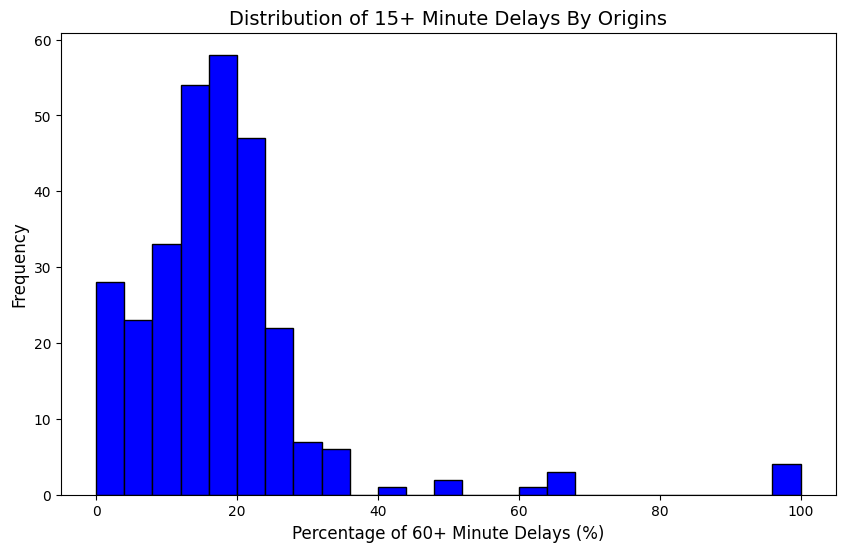

In [31]:

pct_delay_by_origin = train_f.groupby('Origin')['dep_delayed_15min'].mean().sort_values(ascending=False).round(3)*100
pct_delay_by_origin.head(20)
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor='black')
# Add labels and title
plt.title("Distribution of 15+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 60+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()


In [32]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from keras.metrics import AUC

label_encoder = LabelEncoder()

#df['UniqueCarrier'] = label_encoder.fit_transform(df['UniqueCarrier'])
#df['Origin'] = label_encoder.fit_transform(df['Origin'])
#df['Dest'] = label_encoder.fit_transform(df['Dest'])

scaler = StandardScaler()
numeric_cols = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df = pd.get_dummies(df, columns=['UniqueCarrier','Origin','Dest'], drop_first=True)

print(df.head)
X = df.drop(columns=['dep_delayed_15min'])
y = df['dep_delayed_15min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#smote
print(X_train.shape)
cate_indices = [df.columns.get_loc(col) for col in df.select_dtypes(include=['object']).columns]
smote = SMOTE(random_state=42)
X_train1, y_train1 = smote.fit_resample(X_train, y_train)
print(X_train1.shape)

<bound method NDFrame.head of           Month  DayofMonth  DayOfWeek   DepTime  Distance  dep_delayed_15min  \
0      0.428414    0.602254   1.530490  1.243715  0.004530                  0   
1     -0.743428    0.488538  -0.477915  0.433431  0.182040                  0   
2      0.721374   -1.558338   0.526288  0.168934 -0.545405                  0   
3      1.307295    1.057115   1.028389 -0.685433  0.248172                  0   
4      1.014335   -0.989761   1.028389  1.021202 -0.533223                  1   
...         ...         ...        ...       ...       ...                ...   
99995 -0.450468   -1.330908  -0.477915  0.580374 -0.923050                  0   
99996 -1.622310    0.261108  -0.477915 -1.128360  0.269055                  0   
99997 -1.622310    0.943400  -0.980016  1.174442  0.603192                  0   
99998 -0.743428    1.284546   0.024186  0.364158 -1.025727                  0   
99999  1.307295    0.147392   0.024186  0.962425 -0.216488                  0  

In [38]:
model = Sequential()


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[AUC()])

model.fit(X_train1, y_train1, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred_prob = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f'AUC Score: {auc_score:.4f}')
y_pred_binary = (y_pred_prob > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)

Epoch 1/10
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - auc_6: 0.7650 - loss: 0.5637 - val_auc_6: 0.7055 - val_loss: 0.4575
Epoch 2/10
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - auc_6: 0.8932 - loss: 0.3784 - val_auc_6: 0.7121 - val_loss: 0.4591
Epoch 3/10
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - auc_6: 0.9032 - loss: 0.3604 - val_auc_6: 0.7177 - val_loss: 0.4560
Epoch 4/10
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc_6: 0.9086 - loss: 0.3507 - val_auc_6: 0.7136 - val_loss: 0.4478
Epoch 5/10
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - auc_6: 0.9127 - loss: 0.3444 - val_auc_6: 0.7105 - val_loss: 0.4484
Epoch 6/10
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc_6: 0.9151 - loss: 0.3411 - val_auc_6: 0.7125 - val_loss: 0.4473
Epoch 7/10
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc_6: 0.9156 - loss: 0.3392 - val_auc_6: 0.7075 - val_loss: 0.4593
Epoch 8/10
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - auc_6: 0.9150 - loss: 0.3399 - val_auc_6: 0.7097 - val_loss: 0.4542
